In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.utils import shuffle
import numpy as np

In [2]:
a9a = fetch_mldata('a9a')
X, y = a9a.data, a9a.target
random_state = np.random.RandomState(0)
X, y = shuffle(X, y, random_state=random_state)

# undersampling
pos_indices = np.where(y > 0)[0]
neg_indices = np.where(y < 0)[0]
indices = np.sort(np.append(pos_indices, neg_indices[:len(pos_indices)]))
X, y = X[indices], y[indices]
X, y = shuffle(X, y, random_state=random_state)

# train/test split
n_train = int(0.8 * X.shape[0])
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18699, 123) (18699,) (4675, 123) (4675,)


/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# standarize
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Comparison of the accuracy and training/testing time among `SVC` with RBF kernel and `LinearSVC` with random feature

 - `RBFSampler` (=`RandomFourier`)
 - `OrthogonalRandomFeature`
 - `FastFood`
 - `StructuredOrthogonalRandomFeature`
 - `SignedCirculantRandomMatrix` 
 - Higher score is better
 - Lower time is better
 - Unfortunately, structured random features are not so fast since the number of features is small (=123)

In [4]:
%%time
# Non-linear SVC
svc = SVC(kernel='rbf', gamma=0.001, random_state=0)
svc.fit(X_train, y_train)
print(svc.score(X_test, y_test))

0.8151871657754011
CPU times: user 27.3 s, sys: 250 ms, total: 27.6 s
Wall time: 27.7 s


In [5]:
%%time
# LinearSVC with RBFSampler
transformer = RBFSampler(n_components=1024, gamma=0.001, random_state=0)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

0.8220320855614973
CPU times: user 4.75 s, sys: 281 ms, total: 5.03 s
Wall time: 4.99 s


In [6]:
from pyrfm import RandomFourier, FastFood, SignedCirculantRandomMatrix
from pyrfm import OrthogonalRandomFeature, StructuredOrthogonalRandomFeature

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
%%time
# LinearSVC with RandomFourier with use_offset=False (Z=(cos, sin, cos, sin, ...))
transformer = RandomFourier(n_components=1024, gamma=0.001, use_offset=False,
                            random_state=0)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

0.8213903743315508
CPU times: user 4.28 s, sys: 547 ms, total: 4.83 s
Wall time: 4.88 s


In [8]:
%%time
# LinearSVC with RandomFourier with use_offset=True (Z=(cos, cos, ...))
transformer = RandomFourier(n_components=1024, gamma=0.001, use_offset=True,
                            random_state=0)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

0.8220320855614973
CPU times: user 4.92 s, sys: 359 ms, total: 5.28 s
Wall time: 5.28 s


In [9]:
%%time
# LinearSVC with OrthogonalRandomFeature 
transformer = OrthogonalRandomFeature(n_components=1024, gamma=0.001, 
                                      random_state=0)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/pyrfm-0.1.dev0-py3.7-linux-x86_64.egg/pyrfm/random_feature/orthogonal_random_feature.py:117: UserWarning: n_components is changed from 1024 to 1107. You should set n_components to an n-tuple of n_features.
  warnings.warn(msg)
/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/pyrfm-0.1.dev0-py3.7-linux-x86_64.egg/pyrfm/random_feature/orthogonal_random_feature.py:129: UserWarning: n_components is changed from 1107 to 1230. When random_fourier=True and use_offset=False,  n_components should be larger than 2*n_features.
  warnings.warn(msg)


0.8211764705882353
CPU times: user 6.06 s, sys: 891 ms, total: 6.95 s
Wall time: 6.68 s


In [10]:
%%time
# LinearSVC with OrthogonalRandomFeature 
transformer = OrthogonalRandomFeature(n_components=1024, gamma=0.001, 
                                      random_state=0, use_offset=True)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/pyrfm-0.1.dev0-py3.7-linux-x86_64.egg/pyrfm/random_feature/orthogonal_random_feature.py:117: UserWarning: n_components is changed from 1024 to 1107. You should set n_components to an n-tuple of n_features.
  warnings.warn(msg)


0.8224598930481284
CPU times: user 5.33 s, sys: 1.05 s, total: 6.38 s
Wall time: 6.3 s


In [11]:
%%time
# LinearSVC with StructuredOrthogonalRandomFeature
transformer = StructuredOrthogonalRandomFeature(n_components=1024, gamma=0.001, 
                                                random_state=0)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

0.8224598930481284
CPU times: user 5.52 s, sys: 188 ms, total: 5.7 s
Wall time: 5.7 s


In [11]:
%%time
# LinearSVC with FastFood
transformer = FastFood(n_components=1024, gamma=0.001, random_state=0,
                       random_fourier=True)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

0.8222459893048129
CPU times: user 5.17 s, sys: 172 ms, total: 5.34 s
Wall time: 5.38 s


In [12]:
%%time
# LinearSVC with SignedCirculantRandomMatrix
transformer = SignedCirculantRandomMatrix(n_components=1024, gamma=0.001, random_state=0,
                                          random_fourier=True)
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)
clf = LinearSVC(dual=False, C=1)
clf.fit(X_train_trans, y_train)
print(clf.score(X_test_trans, y_test))

/mnt/c/Users/kyohei/home_ubuntu/.local/share/virtualenvs/pipenv3.7.4-rkmnVTJV/lib/python3.7/site-packages/pyrfm-0.1.dev0-py3.7-linux-x86_64.egg/pyrfm/random_feature/signed_circulant_random_projection.py:117: UserWarning: n_components is changed from 1024 to 1107. You should set n_components n-tuple of the n_features.
  .format(self.n_components, n_components))


0.8218181818181818
CPU times: user 7.81 s, sys: 125 ms, total: 7.94 s
Wall time: 8 s


In [13]:
import timeit

### Comparison of the transform times on relativey high-dimensional data among `RBFSampler`, `StructuredOrthogonalRandomFeature`, `Fastfood`, and `SignedCirculantRandomMatrix`
 - Generate datasets with various number of features
 - Lower is better
 - `RBFSampler` (=`RandomFourier`): Linear time
 - Others: Log time


In [14]:
rbf_times = []
fastfood_times = []
struc_times = []
signed_times = []

n_samples = 2**14
n_components = 8192
n_trials = 5
for n_features in [256, 512, 1024, 2048, 4096]:
    print("n_features: {}".format(n_features))
    X_synthesis = np.random.randn(n_samples, n_features)

    rbf = RBFSampler(n_components=n_components)
    result = timeit.timeit("rbf.fit_transform(X_synthesis)", 
                           number=n_trials, globals=globals())
    result /= n_trials
    rbf_times += [result]
    print("RBFSampler: {}".format(result))
    
    struc = StructuredOrthogonalRandomFeature(n_components=n_components)
    result = timeit.timeit("struc.fit_transform(X_synthesis)", 
                           number=n_trials, globals=globals())
    result /= n_trials
    struc_times += [result]
    print("StructuredOrthogonalRandomFeature: {}".format(result))
        
    fastfood = FastFood(n_components=n_components)
    result = timeit.timeit("fastfood.fit_transform(X_synthesis)", 
                           number=n_trials, globals=globals())
    result /= n_trials
    fastfood_times += [result]
    print("FastFood: {}".format(result))

    signed = SignedCirculantRandomMatrix(n_components=n_components)
    result = timeit.timeit("signed.fit_transform(X_synthesis)", 
                           number=n_trials, globals=globals())
    result /= n_trials
    signed_times += [result]
    print("SignedCirculantRandomFeature: {}".format(result))
    print()

print("RBFSampler: {}".format(rbf_times))
print("StructuredOrthogonalRandomFeature: {}".format(struc_times))
print("FastFood: {}".format(fastfood_times))
print("SignedCirculantRandomMatrix: {}".format(signed_times))

n_features: 256
RBFSampler: 6.341798940001172
StructuredOrthogonalRandomFeature: 10.031601940000836
FastFood: 8.455899459999637
SignedCirculantRandomFeature: 19.58160685999901

n_features: 512
RBFSampler: 7.434289660000649
StructuredOrthogonalRandomFeature: 10.474995040000067
FastFood: 8.567313080000167
SignedCirculantRandomFeature: 18.97524861999991

n_features: 1024
RBFSampler: 9.611982019999413
StructuredOrthogonalRandomFeature: 9.94568295999925
FastFood: 8.442773759999545
SignedCirculantRandomFeature: 19.14509861999977

n_features: 2048
RBFSampler: 14.157976419999613
StructuredOrthogonalRandomFeature: 10.252035320000141
FastFood: 8.473272200000064
SignedCirculantRandomFeature: 19.83217255999916

n_features: 4096
RBFSampler: 24.676896960000157
StructuredOrthogonalRandomFeature: 10.095617659999698
FastFood: 8.539829139999346
SignedCirculantRandomFeature: 22.40396458000032

RBFSampler: [6.341798940001172, 7.434289660000649, 9.611982019999413, 14.157976419999613, 24.676896960000157]
St

In [15]:
import matplotlib.pyplot as plt

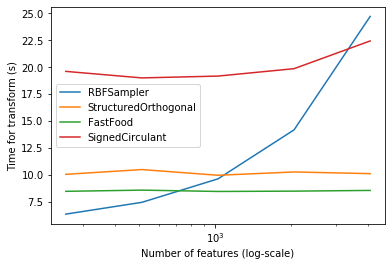

In [16]:
%matplotlib inline
list_n_features = [256, 512, 1024, 2048, 4096]
plt.plot(list_n_features, rbf_times, label='RBFSampler')
plt.plot(list_n_features, struc_times, label='StructuredOrthogonal')
plt.plot(list_n_features, fastfood_times, label='FastFood')
plt.plot(list_n_features, signed_times, label='SignedCirculant')
plt.legend()
plt.xlabel("Number of features (log-scale)")
plt.ylabel("Time for transform (s)")
plt.xscale('log')
plt.show()